# Test/Dev Neural Network Architecture

In [1]:
from __future__ import print_function

import sys
import os
import time

import numpy as np

import chb
import matplotlib.pyplot as plt
from helpers import *

from sklearn.metrics import roc_auc_score, matthews_corrcoef, confusion_matrix

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [47]:
def metrics(npz, thresh=0.8):
    npzlen = int(len(npz.files)/2)
    for i in range(1, npzlen + 1):
        pred = (npz['_'.join(['prob', str(i)])] > thresh).astype('int32')
        mcc = matthews_corrcoef(npz['_'.join(['true', str(i)])], pred)
        cm = confusion_matrix(npz['_'.join(['true', str(i)])], pred)
        print('Matthews Correlation Coefficient: \t{}'.format(mcc))
        print('Confusion matrix:\n{}'.format(cm))

In [48]:
metrics(thurs09)

Matthews Correlation Coefficient: 	0.08196262564399762
Confusion matrix:
[[9503 4823]
 [   7   62]]
Matthews Correlation Coefficient: 	0.1915718784465639
Confusion matrix:
[[12051  2185]
 [   28   132]]
Matthews Correlation Coefficient: 	0.26397210586719944
Confusion matrix:
[[13387   849]
 [   50   110]]
Matthews Correlation Coefficient: 	0.42152239948073217
Confusion matrix:
[[5499  130]
 [  20   47]]


Matthews Correlation Coefficient: 	0.46344335307399176
Confusion matrix:
[[9414   64]
 [  20   34]]
Matthews Correlation Coefficient: 	0.32539768343175923
Confusion matrix:
[[13529   751]
 [   10   106]]
Matthews Correlation Coefficient: 	0.34327438963073664
Confusion matrix:
[[14173    18]
 [  188    40]]
Matthews Correlation Coefficient: 	0.2682911523899964
Confusion matrix:
[[14179    12]
 [  203    25]]


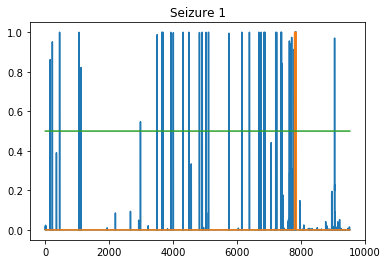

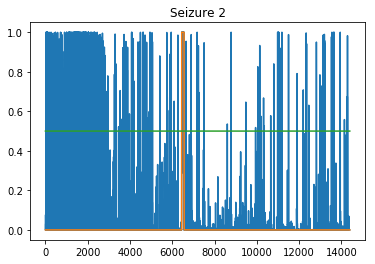

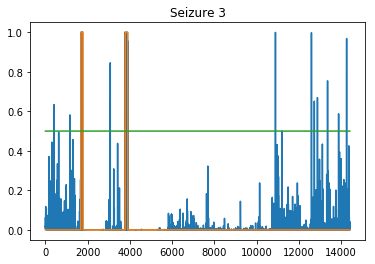

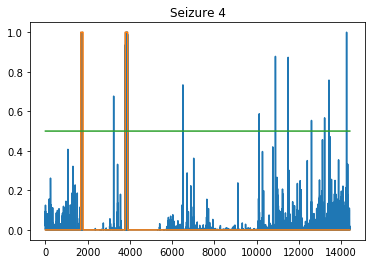

In [72]:
init = np.load('./outputs/chb04init.npz', encoding='latin1')
plotprob(init, 0.5)
metrics(init, 0.5)

In [76]:
chb05 = np.load('./outputs/chb05a5long.npz', encoding='latin1')
print('chb05:',int(len(chb05.files)/2))
chb11 = np.load('./outputs/chb11init.npz', encoding='latin1')
print('chb11:',int(len(chb11.files)/2))
chb17 = np.load('./outputs/chb17init.npz', encoding='latin1')
print('chb17:',int(len(chb17.files)/2))
chb20 = np.load('./outputs/chb20init.npz', encoding='latin1')
print('chb20:',int(len(chb20.files)/2))
chb21 = np.load('./outputs/chb21init.npz', encoding='latin1')
print('chb21:',int(len(chb21.files)/2))
chb22 = np.load('./outputs/chb22init.npz', encoding='latin1')
print('chb22:',int(len(chb22.files)/2))

chb05: 5
chb11: 3
chb17: 3
chb20: 8
chb21: 4
chb22: 3


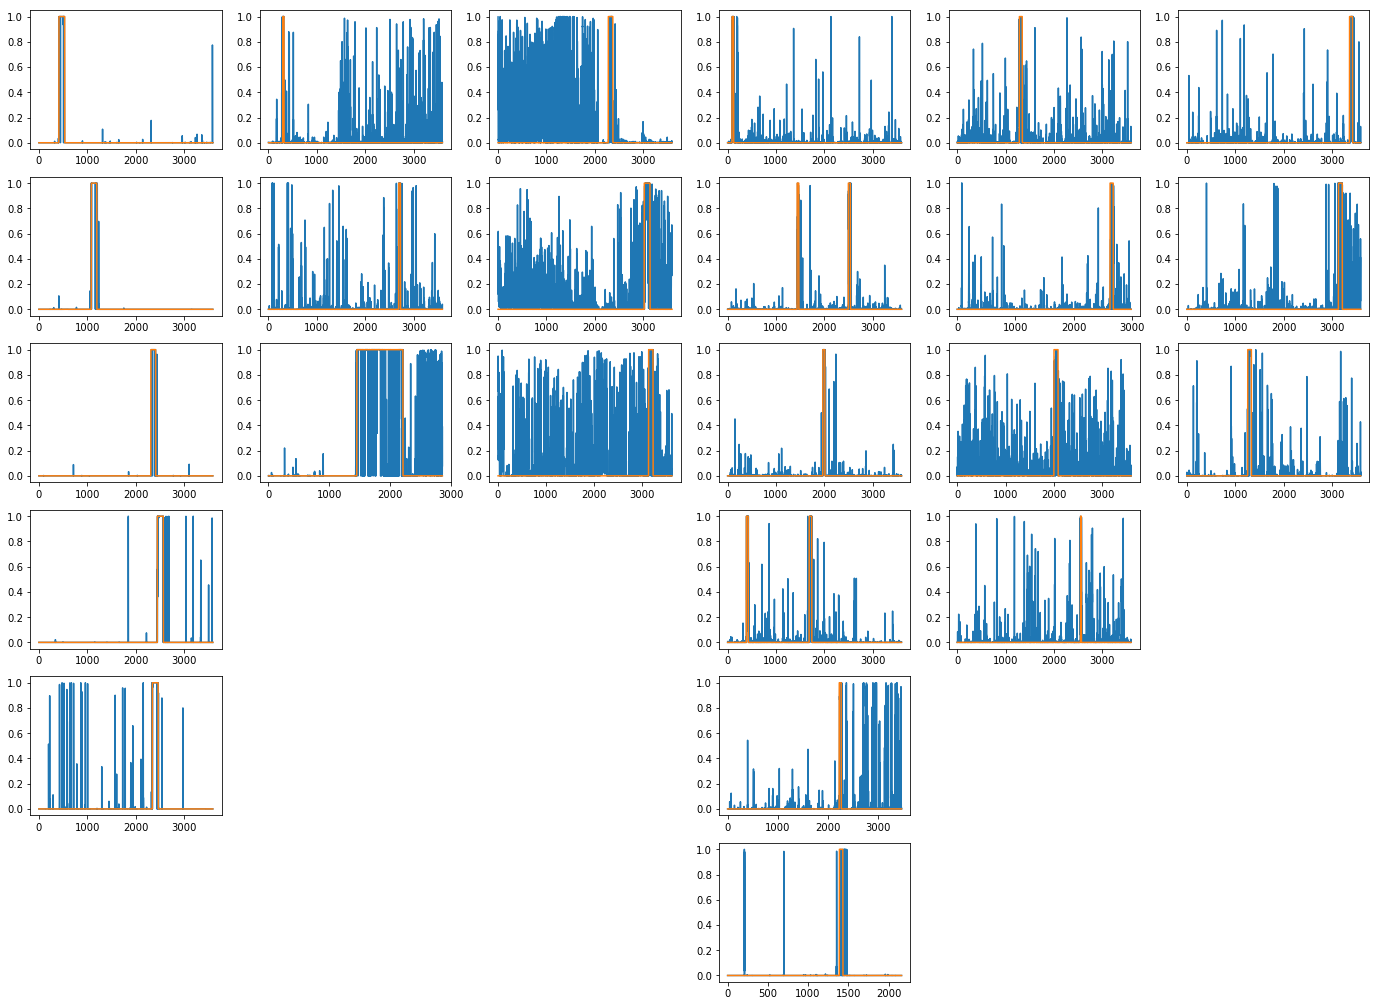

In [89]:
plt.figure(figsize=(24,24))
plt.subplot(8,6,1)
plt.plot(chb05['prob_1'])
plt.plot(chb05['true_1'])
plt.subplot(8,6,2)
plt.plot(chb11['prob_1'])
plt.plot(chb11['true_1'])
plt.subplot(8,6,3)
plt.plot(chb17['prob_1'])
plt.plot(chb17['true_1'])
plt.subplot(8,6,4)
plt.plot(chb20['prob_1'])
plt.plot(chb20['true_1'])
plt.subplot(8,6,5)
plt.plot(chb21['prob_1'])
plt.plot(chb21['true_1'])
plt.subplot(8,6,6)
plt.plot(chb22['prob_1'])
plt.plot(chb22['true_1'])

plt.subplot(8,6,7)
plt.plot(chb05['prob_2'])
plt.plot(chb05['true_2'])
plt.subplot(8,6,8)
plt.plot(chb11['prob_2'])
plt.plot(chb11['true_2'])
plt.subplot(8,6,9)
plt.plot(chb17['prob_2'])
plt.plot(chb17['true_2'])
plt.subplot(8,6,10)
plt.plot(chb20['prob_2'])
plt.plot(chb20['true_2'])
plt.subplot(8,6,11)
plt.plot(chb21['prob_2'])
plt.plot(chb21['true_2'])
plt.subplot(8,6,12)
plt.plot(chb22['prob_2'])
plt.plot(chb22['true_2'])

plt.subplot(8,6,13)
plt.plot(chb05['prob_3'])
plt.plot(chb05['true_3'])
plt.subplot(8,6,14)
plt.plot(chb11['prob_3'])
plt.plot(chb11['true_3'])
plt.subplot(8,6,15)
plt.plot(chb17['prob_3'])
plt.plot(chb17['true_3'])
plt.subplot(8,6,16)
plt.plot(chb20['prob_4'])
plt.plot(chb20['true_4'])
plt.subplot(8,6,17)
plt.plot(chb21['prob_3'])
plt.plot(chb21['true_3'])
plt.subplot(8,6,18)
plt.plot(chb22['prob_3'])
plt.plot(chb22['true_3'])

plt.subplot(8,6,19)
plt.plot(chb05['prob_4'])
plt.plot(chb05['true_4'])
plt.subplot(8,6,22)
plt.plot(chb20['prob_6'])
plt.plot(chb20['true_6'])
plt.subplot(8,6,23)
plt.plot(chb21['prob_4'])
plt.plot(chb21['true_4'])

plt.subplot(8,6,25)
plt.plot(chb05['prob_5'])
plt.plot(chb05['true_5'])
plt.subplot(8,6,28)
plt.plot(chb20['prob_7'])
plt.plot(chb20['true_7'])

plt.subplot(8,6,34)
plt.plot(chb20['prob_8'])
plt.plot(chb20['true_8'])

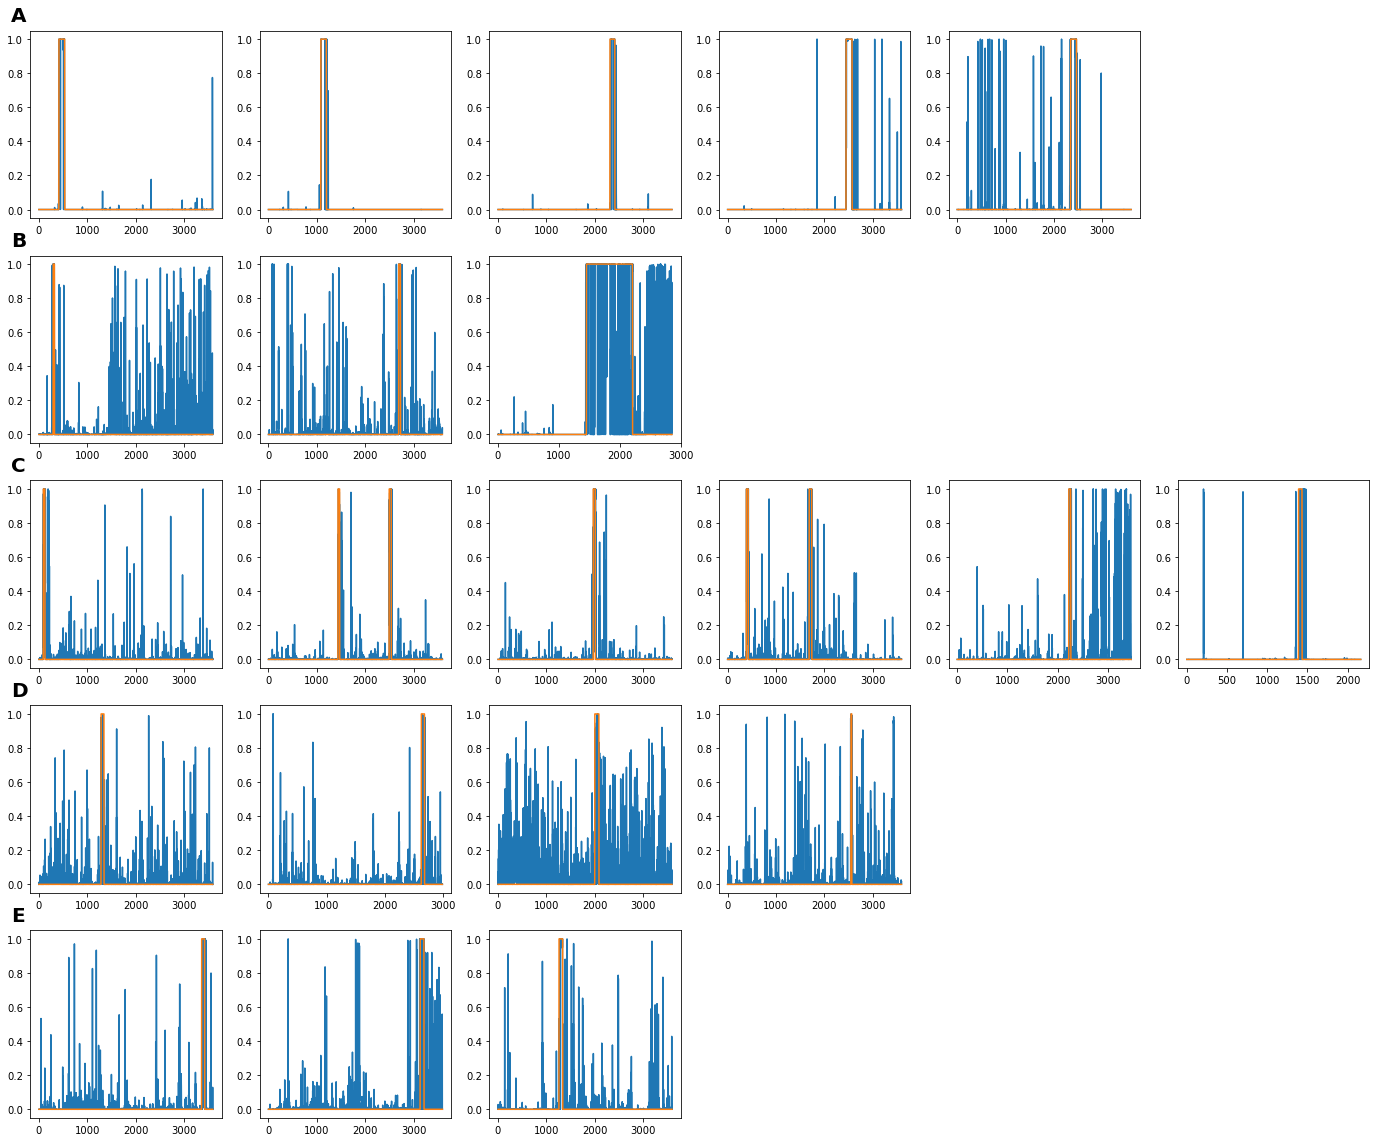

In [103]:
plt.figure(figsize=(24,20))
ax1 = plt.subplot(5,6,1)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
plt.plot(chb05['prob_1'])
plt.plot(chb05['true_1'])
plt.subplot(5,6,2)
plt.plot(chb05['prob_2'])
plt.plot(chb05['true_2'])
plt.subplot(5,6,3)
plt.plot(chb05['prob_3'])
plt.plot(chb05['true_3'])
plt.subplot(5,6,4)
plt.plot(chb05['prob_4'])
plt.plot(chb05['true_4'])
plt.subplot(5,6,5)
plt.plot(chb05['prob_5'])
plt.plot(chb05['true_5'])

ax2 = plt.subplot(5,6,7)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.plot(chb11['prob_1'])
plt.plot(chb11['true_1'])
plt.subplot(5,6,8)
plt.plot(chb11['prob_2'])
plt.plot(chb11['true_2'])
plt.subplot(5,6,9)
plt.plot(chb11['prob_3'])
plt.plot(chb11['true_3'])

ax3 = plt.subplot(5,6,13)
ax3.text(-0.1, 1.05, 'C', transform=ax3.transAxes, 
            size=20, weight='bold')
plt.plot(chb20['prob_1'])
plt.plot(chb20['true_1'])
plt.subplot(5,6,14)
plt.plot(chb20['prob_2'])
plt.plot(chb20['true_2'])
plt.subplot(5,6,15)
plt.plot(chb20['prob_4'])
plt.plot(chb20['true_4'])
plt.subplot(5,6,16)
plt.plot(chb20['prob_6'])
plt.plot(chb20['true_6'])
plt.subplot(5,6,17)
plt.plot(chb20['prob_7'])
plt.plot(chb20['true_7'])
plt.subplot(5,6,18)
plt.plot(chb20['prob_8'])
plt.plot(chb20['true_8'])

ax4 = plt.subplot(5,6,19)
ax4.text(-0.1, 1.05, 'D', transform=ax4.transAxes, 
            size=20, weight='bold')
plt.plot(chb21['prob_1'])
plt.plot(chb21['true_1'])
plt.subplot(5,6,20)
plt.plot(chb21['prob_2'])
plt.plot(chb21['true_2'])
plt.subplot(5,6,21)
plt.plot(chb21['prob_3'])
plt.plot(chb21['true_3'])
plt.subplot(5,6,22)
plt.plot(chb21['prob_4'])
plt.plot(chb21['true_4'])

ax5 = plt.subplot(5,6,25)
ax5.text(-0.1, 1.05, 'E', transform=ax5.transAxes, 
            size=20, weight='bold')
plt.plot(chb22['prob_1'])
plt.plot(chb22['true_1'])
plt.subplot(5,6,26)
plt.plot(chb22['prob_2'])
plt.plot(chb22['true_2'])
plt.subplot(5,6,27)
plt.plot(chb22['prob_3'])
plt.plot(chb22['true_3'])

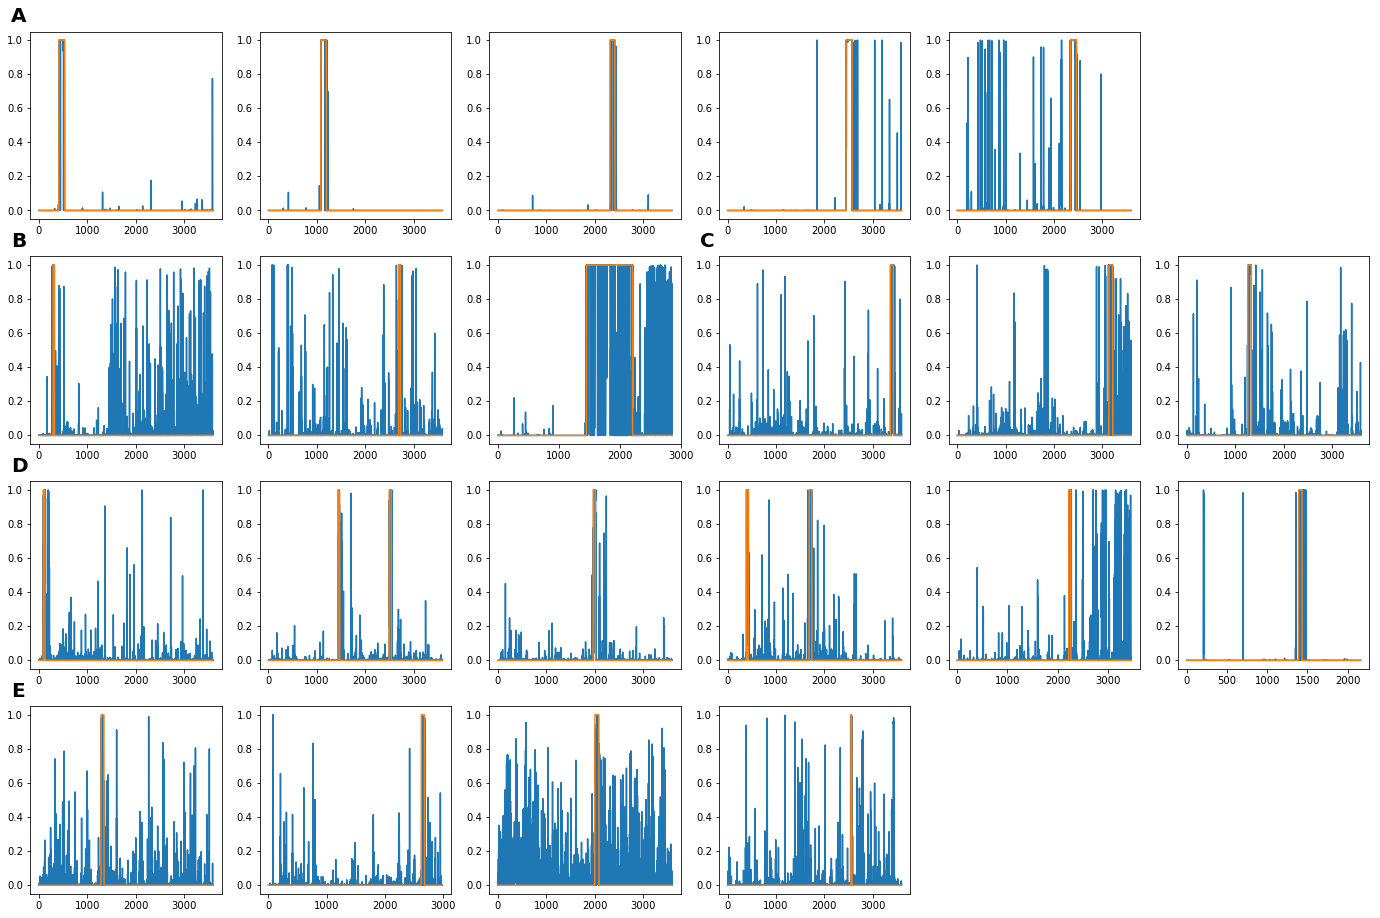

In [114]:
plt.figure(figsize=(24,20))
ax1 = plt.subplot(5,6,1)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
plt.plot(chb05['prob_1'])
plt.plot(chb05['true_1'])
plt.subplot(5,6,2)
plt.plot(chb05['prob_2'])
plt.plot(chb05['true_2'])
plt.subplot(5,6,3)
plt.plot(chb05['prob_3'])
plt.plot(chb05['true_3'])
plt.subplot(5,6,4)
plt.plot(chb05['prob_4'])
plt.plot(chb05['true_4'])
plt.subplot(5,6,5)
plt.plot(chb05['prob_5'])
plt.plot(chb05['true_5'])

ax2 = plt.subplot(5,6,7)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.plot(chb11['prob_1'])
plt.plot(chb11['true_1'])
plt.subplot(5,6,8)
plt.plot(chb11['prob_2'])
plt.plot(chb11['true_2'])
plt.subplot(5,6,9)
plt.plot(chb11['prob_3'])
plt.plot(chb11['true_3'])

ax5 = plt.subplot(5,6,10)
ax5.text(-0.1, 1.05, 'C', transform=ax5.transAxes, 
            size=20, weight='bold')
plt.plot(chb22['prob_1'])
plt.plot(chb22['true_1'])
plt.subplot(5,6,11)
plt.plot(chb22['prob_2'])
plt.plot(chb22['true_2'])
plt.subplot(5,6,12)
plt.plot(chb22['prob_3'])
plt.plot(chb22['true_3'])

ax3 = plt.subplot(5,6,13)
ax3.text(-0.1, 1.05, 'D', transform=ax3.transAxes, 
            size=20, weight='bold')
plt.plot(chb20['prob_1'])
plt.plot(chb20['true_1'])
plt.subplot(5,6,14)
plt.plot(chb20['prob_2'])
plt.plot(chb20['true_2'])
plt.subplot(5,6,15)
plt.plot(chb20['prob_4'])
plt.plot(chb20['true_4'])
plt.subplot(5,6,16)
plt.plot(chb20['prob_6'])
plt.plot(chb20['true_6'])
plt.subplot(5,6,17)
plt.plot(chb20['prob_7'])
plt.plot(chb20['true_7'])
plt.subplot(5,6,18)
plt.plot(chb20['prob_8'])
plt.plot(chb20['true_8'])

ax4 = plt.subplot(5,6,19)
ax4.text(-0.1, 1.05, 'E', transform=ax4.transAxes, 
            size=20, weight='bold')
plt.plot(chb21['prob_1'])
plt.plot(chb21['true_1'])
plt.subplot(5,6,20)
plt.plot(chb21['prob_2'])
plt.plot(chb21['true_2'])
plt.subplot(5,6,21)
plt.plot(chb21['prob_3'])
plt.plot(chb21['true_3'])
plt.subplot(5,6,22)
plt.plot(chb21['prob_4'])
plt.plot(chb21['true_4'])

The figure above includes the subjects for which a first pass with the ConvNet produced favorable results. The subjects are CHB05, CHB11, CHB20, CHB21, and CHB22. The columns show the output of the ConvNet tested on the seizure file, trained on all others (Leave-One-Out testing). For CHB20, the better of the outputs was chosen for each file that contains two seizures, though they were comparable.

In [112]:
chb01 = np.load('./outputs/chb01us.npz', encoding='latin1')
print('chb01:',int(len(chb01.files)/2))
chb03 = np.load('./outputs/chb03init.npz', encoding='latin1')
print('chb03:',int(len(chb03.files)/2))
chb07 = np.load('./outputs/chb07init.npz', encoding='latin1')
print('chb07:',int(len(chb07.files)/2))
chb08 = np.load('./outputs/chb08init.npz', encoding='latin1')
print('chb08:',int(len(chb08.files)/2))
chb17 = np.load('./outputs/chb17init.npz', encoding='latin1')
print('chb17:',int(len(chb17.files)/2))
chb18 = np.load('./outputs/chb18init.npz', encoding='latin1')
print('chb18:',int(len(chb18.files)/2))
chb19 = np.load('./outputs/chb19init.npz', encoding='latin1')
print('chb19:',int(len(chb19.files)/2))

chb01: 7
chb03: 7
chb07: 3
chb08: 5
chb17: 3
chb18: 6
chb19: 3


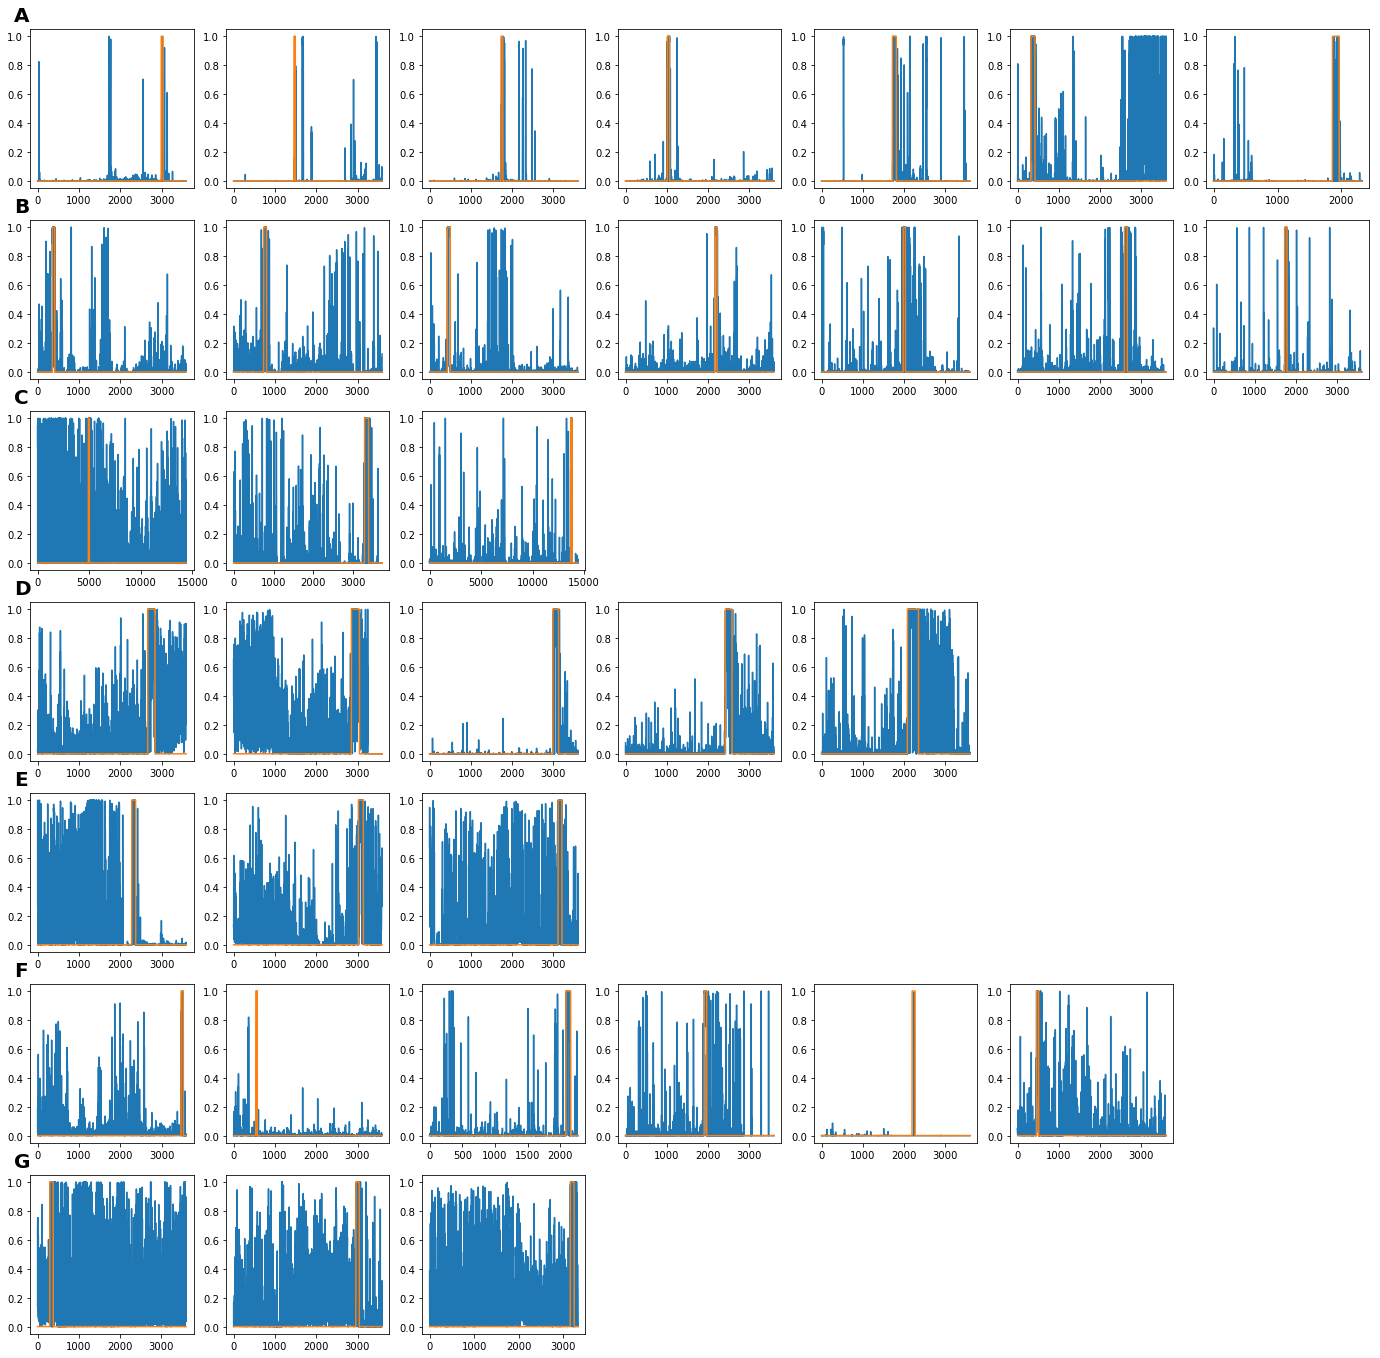

In [111]:
plt.figure(figsize=(24,24))
ax1 = plt.subplot(7,7,1)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
plt.plot(chb01['prob_1'])
plt.plot(chb01['true_1'])
plt.subplot(7,7,2)
plt.plot(chb01['prob_2'])
plt.plot(chb01['true_2'])
plt.subplot(7,7,3)
plt.plot(chb01['prob_3'])
plt.plot(chb01['true_3'])
plt.subplot(7,7,4)
plt.plot(chb01['prob_4'])
plt.plot(chb01['true_4'])
plt.subplot(7,7,5)
plt.plot(chb01['prob_5'])
plt.plot(chb01['true_5'])
plt.subplot(7,7,6)
plt.plot(chb01['prob_6'])
plt.plot(chb01['true_6'])
plt.subplot(7,7,7)
plt.plot(chb01['prob_7'])
plt.plot(chb01['true_7'])

ax2 = plt.subplot(7,7,8)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.plot(chb03['prob_1'])
plt.plot(chb03['true_1'])
plt.subplot(7,7,9)
plt.plot(chb03['prob_2'])
plt.plot(chb03['true_2'])
plt.subplot(7,7,10)
plt.plot(chb03['prob_3'])
plt.plot(chb03['true_3'])
plt.subplot(7,7,11)
plt.plot(chb03['prob_4'])
plt.plot(chb03['true_4'])
plt.subplot(7,7,12)
plt.plot(chb03['prob_5'])
plt.plot(chb03['true_5'])
plt.subplot(7,7,13)
plt.plot(chb03['prob_6'])
plt.plot(chb03['true_6'])
plt.subplot(7,7,14)
plt.plot(chb03['prob_7'])
plt.plot(chb03['true_7'])

ax3 = plt.subplot(7,7,15)
ax3.text(-0.1, 1.05, 'C', transform=ax3.transAxes, 
            size=20, weight='bold')
plt.plot(chb07['prob_1'])
plt.plot(chb07['true_1'])
plt.subplot(7,7,16)
plt.plot(chb07['prob_2'])
plt.plot(chb07['true_2'])
plt.subplot(7,7,17)
plt.plot(chb07['prob_3'])
plt.plot(chb07['true_3'])

ax4 = plt.subplot(7,7,22)
ax4.text(-0.1, 1.05, 'D', transform=ax4.transAxes, 
            size=20, weight='bold')
plt.plot(chb08['prob_1'])
plt.plot(chb08['true_1'])
plt.subplot(7,7,23)
plt.plot(chb08['prob_2'])
plt.plot(chb08['true_2'])
plt.subplot(7,7,24)
plt.plot(chb08['prob_3'])
plt.plot(chb08['true_3'])
plt.subplot(7,7,25)
plt.plot(chb08['prob_4'])
plt.plot(chb08['true_4'])
plt.subplot(7,7,26)
plt.plot(chb08['prob_5'])
plt.plot(chb08['true_5'])

ax5 = plt.subplot(7,7,29)
ax5.text(-0.1, 1.05, 'E', transform=ax5.transAxes, 
            size=20, weight='bold')
plt.plot(chb17['prob_1'])
plt.plot(chb17['true_1'])
plt.subplot(7,7,30)
plt.plot(chb17['prob_2'])
plt.plot(chb17['true_2'])
plt.subplot(7,7,31)
plt.plot(chb17['prob_3'])
plt.plot(chb17['true_3'])

ax6 = plt.subplot(7,7,36)
ax6.text(-0.1, 1.05, 'F', transform=ax6.transAxes, 
            size=20, weight='bold')
plt.plot(chb18['prob_1'])
plt.plot(chb18['true_1'])
plt.subplot(7,7,37)
plt.plot(chb18['prob_2'])
plt.plot(chb18['true_2'])
plt.subplot(7,7,38)
plt.plot(chb18['prob_3'])
plt.plot(chb18['true_3'])
plt.subplot(7,7,39)
plt.plot(chb18['prob_4'])
plt.plot(chb18['true_4'])
plt.subplot(7,7,40)
plt.plot(chb18['prob_5'])
plt.plot(chb18['true_5'])
plt.subplot(7,7,41)
plt.plot(chb18['prob_6'])
plt.plot(chb18['true_6'])

ax7 = plt.subplot(7,7,43)
ax7.text(-0.1, 1.05, 'G', transform=ax7.transAxes, 
            size=20, weight='bold')
plt.plot(chb19['prob_1'])
plt.plot(chb19['true_1'])
plt.subplot(7,7,44)
plt.plot(chb19['prob_2'])
plt.plot(chb19['true_2'])
plt.subplot(7,7,45)
plt.plot(chb19['prob_3'])
plt.plot(chb19['true_3'])

In [107]:
chb02 = np.load('./outputs/chb02init.npz', encoding='latin1')
print('chb02:',int(len(chb02.files)/2))
chb04 = np.load('./outputs/chb04init.npz', encoding='latin1')
print('chb04:',int(len(chb04.files)/2))
chb09 = np.load('./outputs/chb09us3.npz', encoding='latin1')
print('chb09:',int(len(chb09.files)/2))

chb02: 2
chb04: 4
chb09: 4


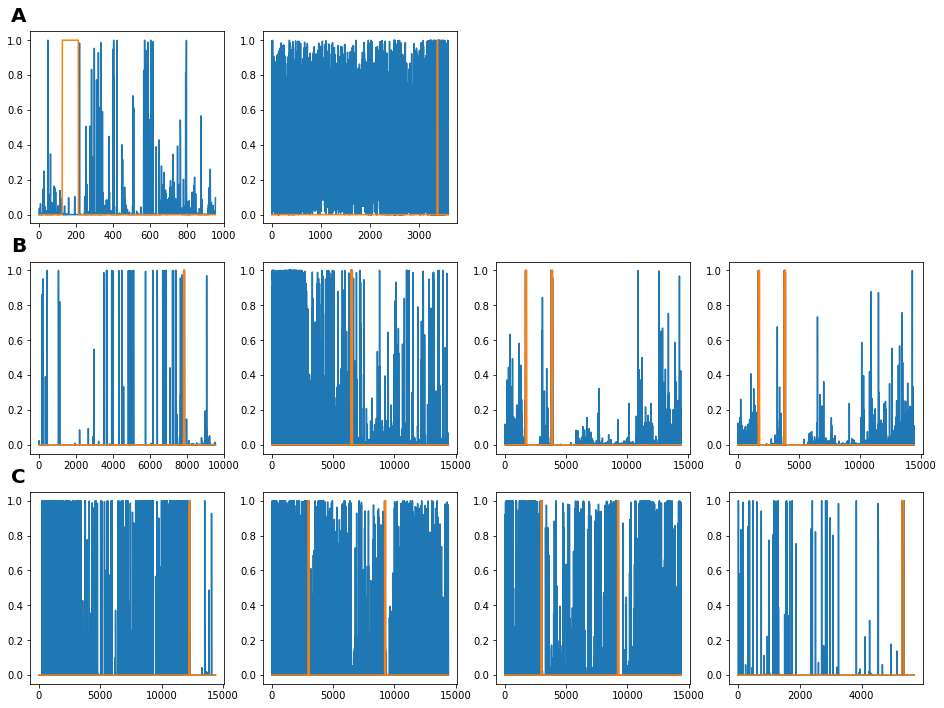

In [117]:
plt.figure(figsize=(16,12))
ax1 = plt.subplot(3,4,1)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
plt.plot(chb02['prob_1'])
plt.plot(chb02['true_1'])
plt.subplot(3,4,2)
plt.plot(chb02['prob_2'])
plt.plot(chb02['true_2'])


ax2 = plt.subplot(3,4,5)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.plot(chb04['prob_1'])
plt.plot(chb04['true_1'])
plt.subplot(3,4,6)
plt.plot(chb04['prob_2'])
plt.plot(chb04['true_2'])
plt.subplot(3,4,7)
plt.plot(chb04['prob_3'])
plt.plot(chb04['true_3'])
plt.subplot(3,4,8)
plt.plot(chb04['prob_4'])
plt.plot(chb04['true_4'])


ax3 = plt.subplot(3,4,9)
ax3.text(-0.1, 1.05, 'C', transform=ax3.transAxes, 
            size=20, weight='bold')
plt.plot(chb09['prob_1'])
plt.plot(chb09['true_1'])
plt.subplot(3,4,10)
plt.plot(chb09['prob_2'])
plt.plot(chb09['true_2'])
plt.subplot(3,4,11)
plt.plot(chb09['prob_3'])
plt.plot(chb09['true_3'])
plt.subplot(3,4,12)
plt.plot(chb09['prob_4'])
plt.plot(chb09['true_4'])

In [115]:
chb10 = np.load('./outputs/chb10init.npz', encoding='latin1')

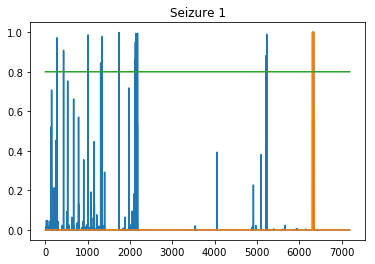

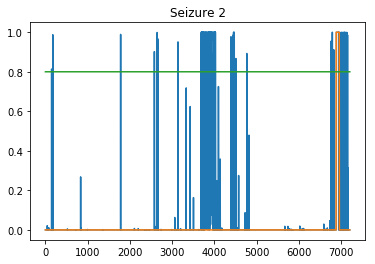

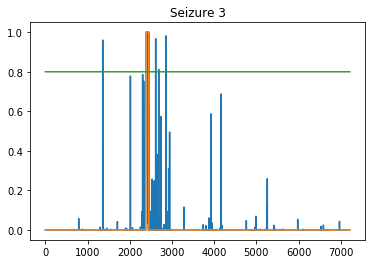

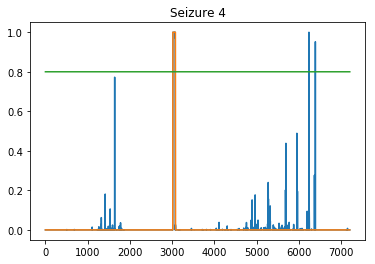

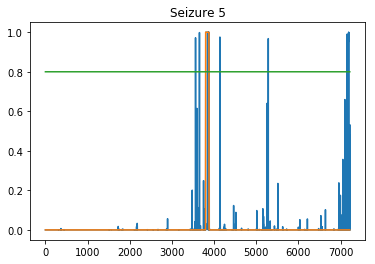

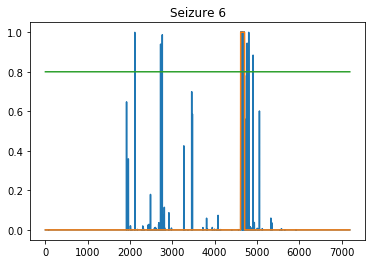

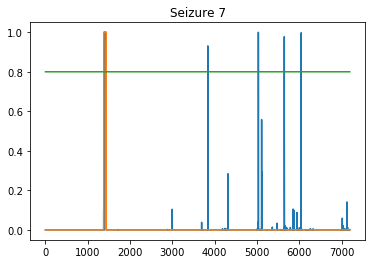

In [116]:
plotprob(chb10)

In [151]:
x = np.random.random_sample((10,2))
x[:,0] = (x[:,0] * 4).astype('int') + 3

In [152]:
x

array([[ 6.        ,  0.97279509],
       [ 5.        ,  0.47548674],
       [ 6.        ,  0.26039901],
       [ 3.        ,  0.48998689],
       [ 4.        ,  0.5038716 ],
       [ 4.        ,  0.94076041],
       [ 4.        ,  0.062816  ],
       [ 3.        ,  0.03713701],
       [ 6.        ,  0.07069546],
       [ 6.        ,  0.12884357]])